Import libraries

In [1]:
import os
import sys
from getpass import getpass
import git
import torch.optim as optim

Configure Environment

In [2]:
os.environ["ENVIRONMENT"] = "windows"
os.environ["REPO_DIR"] = git.Repo(search_parent_directories=True).git.rev_parse("--show-toplevel")
os.environ["ROOT_DIR"] = os.path.abspath(os.path.join(os.getenv("REPO_DIR"), os.pardir))
os.environ["MODEL_ID"] = "32mw3qk4"
os.environ["MODEL_DIR"] = f"{os.getenv('REPO_DIR')}/models/model_{os.getenv('MODEL_ID')}"

Import Repository Resources

In [3]:
sys.path.insert(0, f"{os.getenv('REPO_DIR')}/src")
from helpers import *

sys.path.insert(0, f"{os.getenv('MODEL_DIR')}/src")
from methods import *
from architecture import *
from dataset import *

Download Datasets

In [4]:
dbx_access_token = getpass("Enter your DropBox access token: ")

In [5]:
# Set to True if datasets need to be downloaded to your local machine
download_datasets = False

if download_datasets:
    download_datasets_from_dropbox(
        dbx_access_token = dbx_access_token,
        include_all_datasets = True,
        use_thread = True
    )

Code

In [6]:
num_epochs = 20
batch_size = 10
val_batch_size = 10
val_ratio = 0.2                         # Percent of training set used for validation
lookback = {"count": 0, "stride": 1}    # Prior frames model has access to

In [7]:
device = set_device()
model = initialize_model(
    device = device,
    dbx_access_token = dbx_access_token,
    lookback = lookback,
    reset_weights = False
)

train_dataset, val_dataset = create_datasets(
    device = device,
    include_all_datasets = False,
    include_real_world_datasets = True,
    val_ratio = val_ratio,
    lookback = lookback
)

train_dataloader, val_dataloader = create_dataloaders(
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    batch_size = batch_size,
    val_batch_size = val_batch_size
)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Using GPU!
Downloaded model weights from Dropbox.


Starting training...


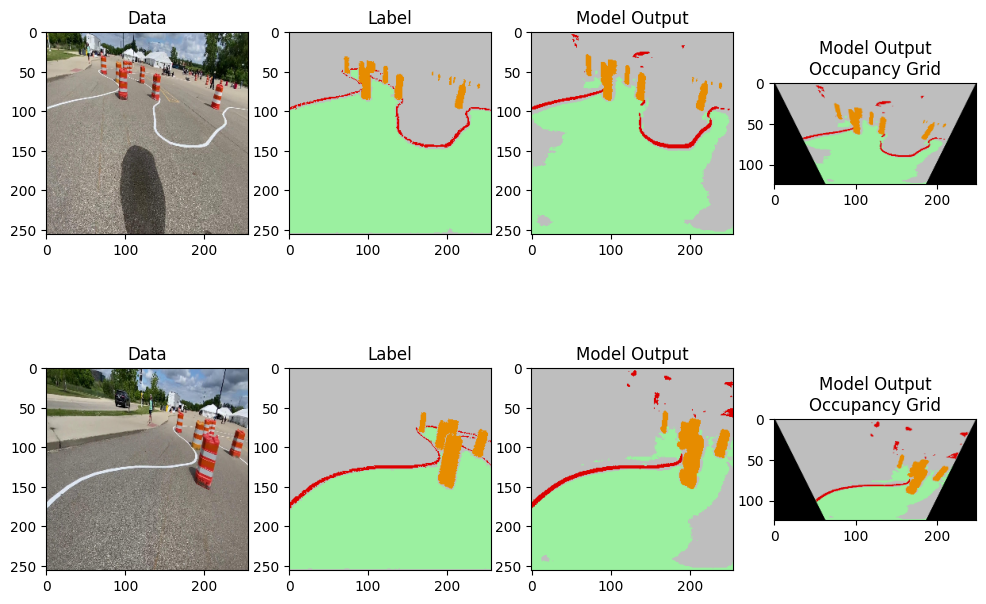

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

[EPOCH 1/20]  Train Loss: 0.3076  <>  Val Accuracy: 26.70%  <>  Val Mean IoU: 11.84%
[EPOCH 5/20]  Train Loss: 0.2234  <>  Val Accuracy: 26.34%  <>  Val Mean IoU: 11.71%


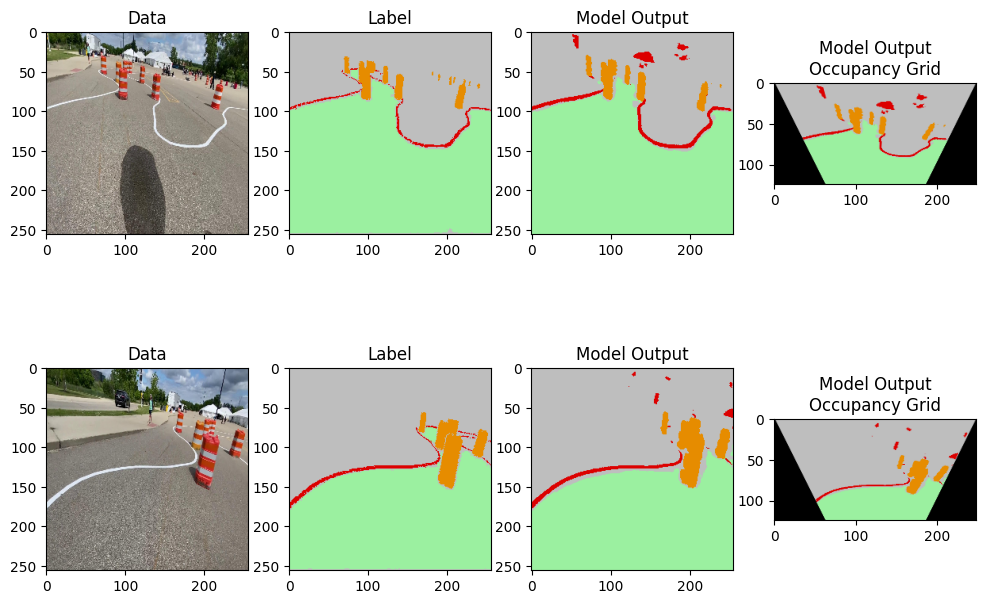

[EPOCH 10/20]  Train Loss: 0.2875  <>  Val Accuracy: 26.55%  <>  Val Mean IoU: 11.75%
[EPOCH 11/20]  No improvement in validation Accuracy for 10 epochs
[EPOCH 15/20]  Train Loss: 0.2661  <>  Val Accuracy: 26.69%  <>  Val Mean IoU: 11.83%


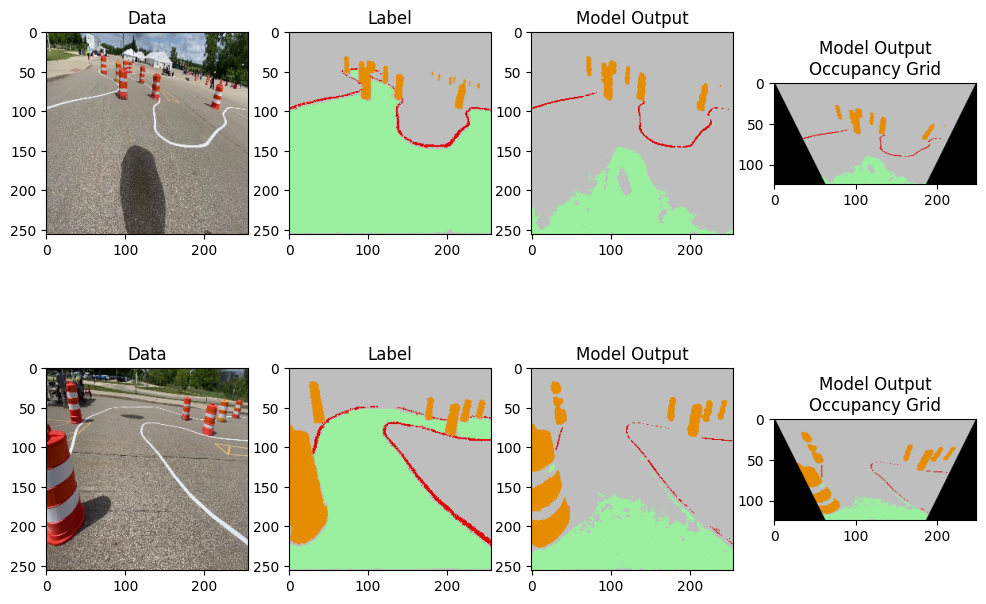

[EPOCH 20/20]  Train Loss: 0.2592  <>  Val Accuracy: 23.81%  <>  Val Mean IoU: 10.71%

Training done!
20 epochs completed
Final Model Metrics:  Train Loss: 0.2592  <>  Val Accuracy: 23.81%  <>  Val Mean IoU: 10.71%



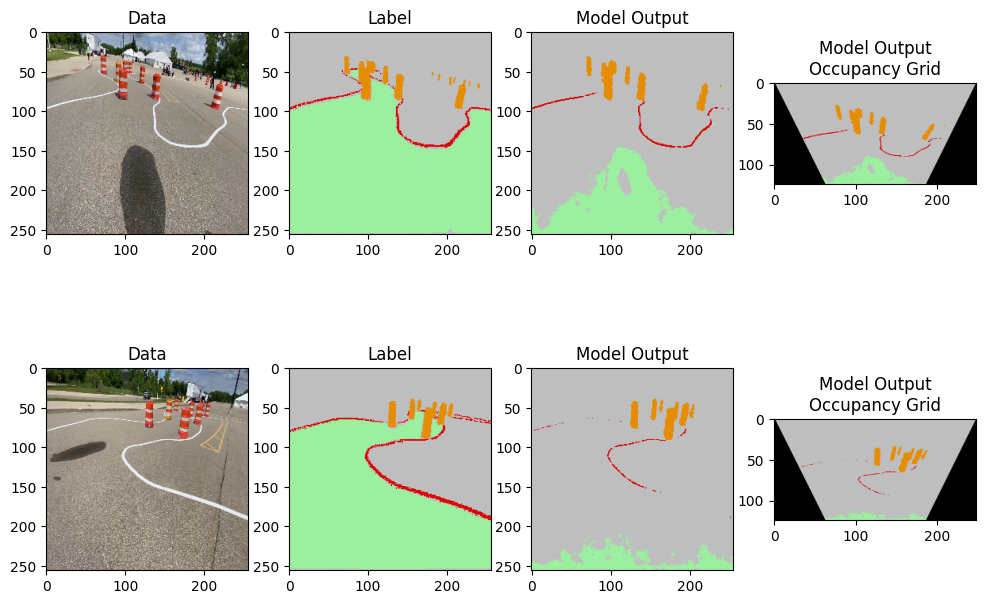

Uploaded model weights to Dropbox.


In [8]:
model, train_loss_hist, val_performance_hist, best_val_performance = training_loop(
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    val_dataset = val_dataset,
    dbx_access_token = dbx_access_token,
    num_epochs = num_epochs,
    critiqueing_metric = "Accuracy",
    auto_stop = False,
    verbose=True,
    display_sample_results = False
)

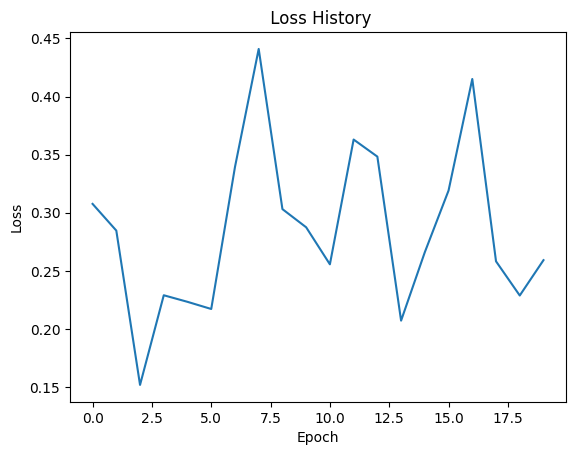

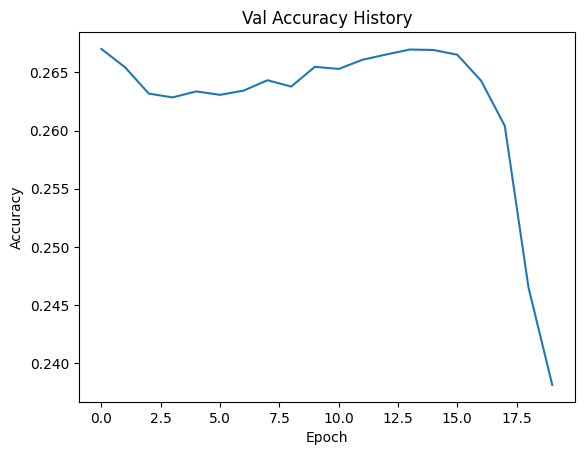

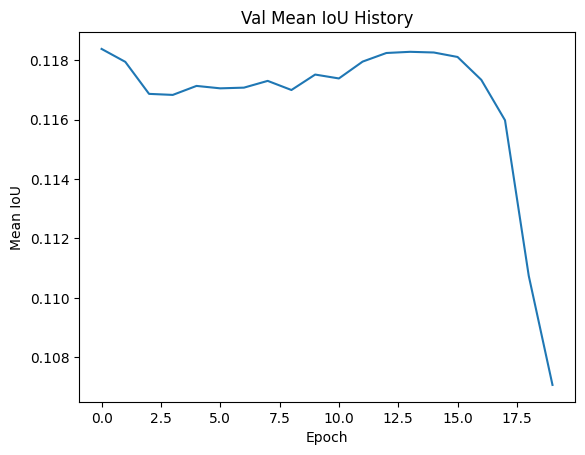

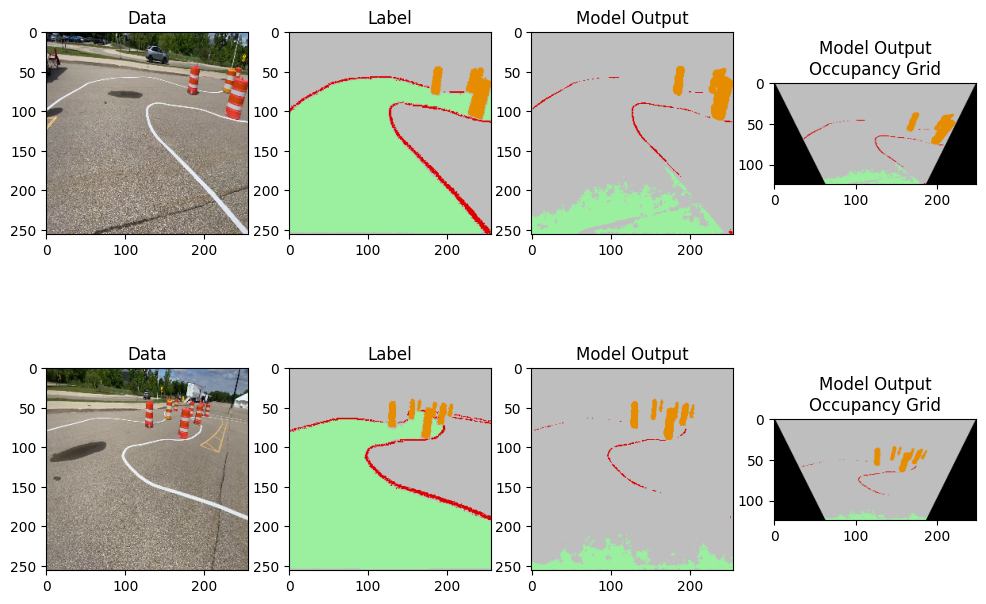

In [9]:
graph_loss_history(train_loss_hist)

graph_performance_history(
    performance_hist = val_performance_hist,
    split = "Val",
    metrics = ["Accuracy", "Mean IoU"]
)

show_sample_results(
    model = model,
    dataset = val_dataset,
    device = device,
    num_samples = 2
)

Testing on comp24_walkthrough:   0%|          | 0/99 [00:00<?, ? frame/s]


comp24_walkthrough metrics:
	Accuracy: 0.2390
	Background Precision: 0.4240
	Background Recall: 0.2689
	Background Specificity: 0.6871
	Background F1 Score: 0.3291
	Background IoU: 0.1969
	Background Dice Coefficient: 0.3291
	Lane Lines Precision: 0.0327
	Lane Lines Recall: 0.2062
	Lane Lines Specificity: 0.7945
	Lane Lines F1 Score: 0.0565
	Lane Lines IoU: 0.0291
	Lane Lines Dice Coefficient: 0.0565
	Drivable Area Precision: 0.4913
	Drivable Area Recall: 0.2040
	Drivable Area Specificity: 0.8151
	Drivable Area F1 Score: 0.2883
	Drivable Area IoU: 0.1684
	Drivable Area Dice Coefficient: 0.2883
	Cones Precision: 0.0422
	Cones Recall: 0.3324
	Cones Specificity: 0.6930
	Cones F1 Score: 0.0748
	Cones IoU: 0.0389
	Cones Dice Coefficient: 0.0748
	Mean IoU: 0.1083
	Mean Dice Coefficient: 0.1872

Metrics saved in performance.json for benchmark "comp24_walkthrough".


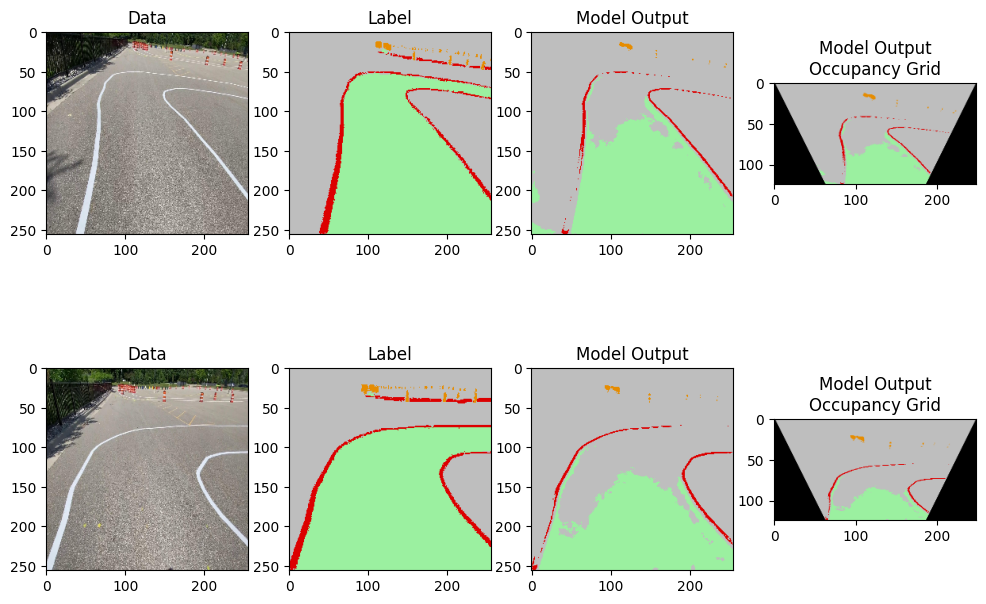

In [10]:
test_model_on_benchmarks(
    model = model,
    device = device,
    all_benchmarks = True,
    num_sample_results = 2,
    lookback = lookback
)